# HDB Resale Flat Price Prediction
# Data Source: 24S2-CB0494 INTRO TO DSAI (LAB)

## 1. Import Required Libraries and Dependencies

In [1]:
# Import Required Libraries and Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

# For preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# For Linear Regression
from sklearn.linear_model import LinearRegression

# For Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Set visualization style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Display settings for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.width', 200)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Explore the Dataset Directly from CSV File on GitHub

In [2]:
# Import Required Libraries and Dependencies
import pandas as pd

# Load Dataset Directly from GitHub (No Local File Needed)
github_url = "https://github.com/gracenngg/CB0494-HDB-Price-Predictions/blob/4586b7e4fe44f33c441b708ef294adc8c282e7c9/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv?raw=true"

try:
    # Try to load from GitHub
    df = pd.read_csv(github_url)
    print("Data source: 24S2-CB0494-INTRO TO DATA SCI & ART INTELL (TUT)")
    print("Successfully loaded data from GitHub")
    
    # Display basic information about the dataset
    print(f"\nDataset shape: {df.shape}")
    
    # Display the first few rows
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    
    # Check for missing values
    print("\nMissing values count:")
    print(df.isnull().sum())
    
    # Check statistical summary of numerical columns
    print("\nStatistical summary:")
    print(df.describe())
    
    # Check correlation with resale price for numerical columns
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if 'resale_price' in numerical_cols:
        correlations = df[numerical_cols].corr()['resale_price'].sort_values(ascending=False)
        print("\nCorrelations with resale price:")
        print(correlations)
    
except Exception as e:
    print(f"Error loading data from GitHub: {e}")
    print("\nTo fix this issue:")
    print("1. Make sure your CSV file is uploaded to GitHub")
    print("2. Get the correct raw URL by:")
    print("   a. Navigate to your file on GitHub")
    print("   b. Click the 'Raw' button")
    print("   c. Copy the URL from your browser's address bar")
    print("   d. Replace the github_url in the code with this URL")

Data source: 24S2-CB0494-INTRO TO DATA SCI & ART INTELL (TUT)
Successfully loaded data from GitHub

Dataset shape: (201410, 11)

First 5 rows of the dataset:
     month        town flat_type block        street_name storey_range  floor_area_sqm      flat_model  lease_commence_date     remaining_lease  resale_price
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12           44.00        Improved                 1979  61 years 04 months     232000.00
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03           67.00  New Generation                 1978  60 years 07 months     250000.00
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03           67.00  New Generation                 1980  62 years 05 months     262000.00
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06           68.00  New Generation                 1980   62 years 01 month     265000.00
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO 

## 3. Explore Data Types and Check for Missing Values

In [3]:
# Check data types
print("Data types:")
print(df.dtypes)

# Check for missing values
print("\nMissing values count:")
print(df.isnull().sum())

# Display summary statistics
print("\nSummary statistics:")
df.describe()

Data types:
month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object

Missing values count:
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

Summary statistics:


,floor_area_sqm,lease_commence_date,resale_price
count,201410.00,201410.00,201410.00
mean,96.95,1996.24,511052.67
std,24.03,14.18,179241.46
min,31.00,1966.00,140000.00
25%,82.00,1985.00,380000.00
50%,93.00,1996.00,480000.00
75%,112.00,2011.00,610000.00
max,366.70,2021.00,1600000.00


## 4. Exploratory Data Analysis: Distribution of Resale Prices

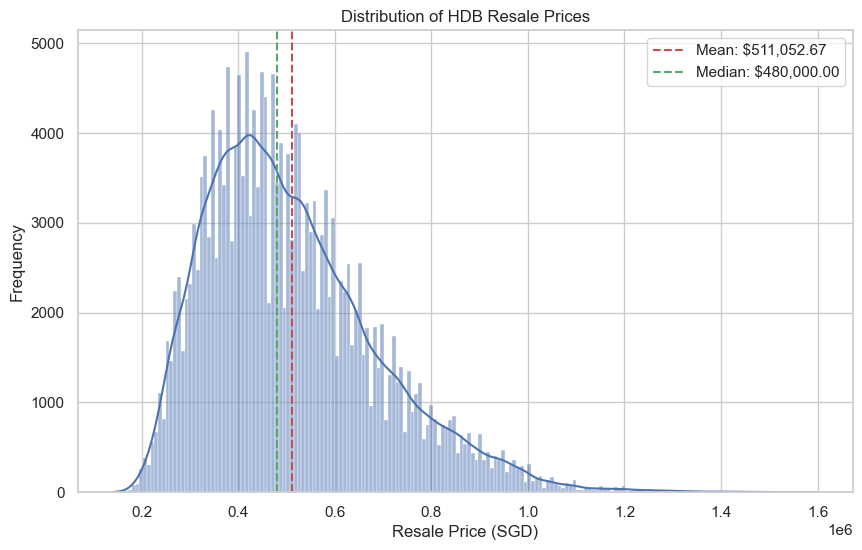

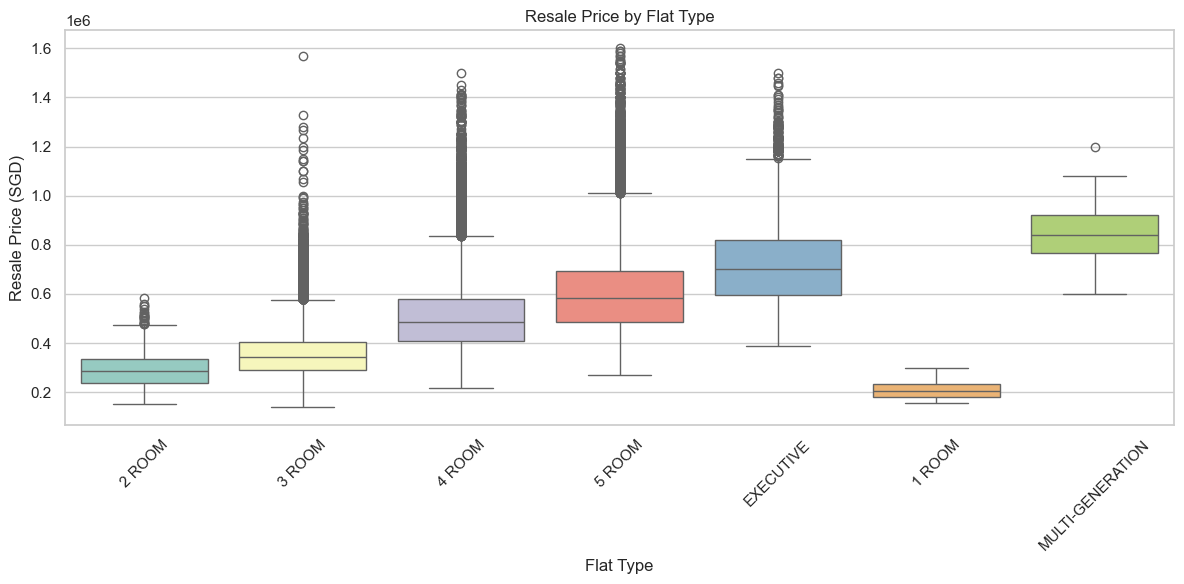

In [4]:
# Plot the distribution of resale prices
plt.figure(figsize=(10, 6))
sns.histplot(df['resale_price'], kde=True)
plt.title('Distribution of HDB Resale Prices')
plt.xlabel('Resale Price (SGD)')
plt.ylabel('Frequency')
plt.axvline(df['resale_price'].mean(), color='r', linestyle='--', label=f'Mean: ${df["resale_price"].mean():,.2f}')
plt.axvline(df['resale_price'].median(), color='g', linestyle='--', label=f'Median: ${df["resale_price"].median():,.2f}')
plt.legend()
plt.show()

# Plot resale price by flat type
plt.figure(figsize=(12, 6))
sns.boxplot(x='flat_type', y='resale_price', data=df, palette='Set3')
plt.title('Resale Price by Flat Type')
plt.xlabel('Flat Type')
plt.ylabel('Resale Price (SGD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Analyze Price Trends by Location and Flat Type

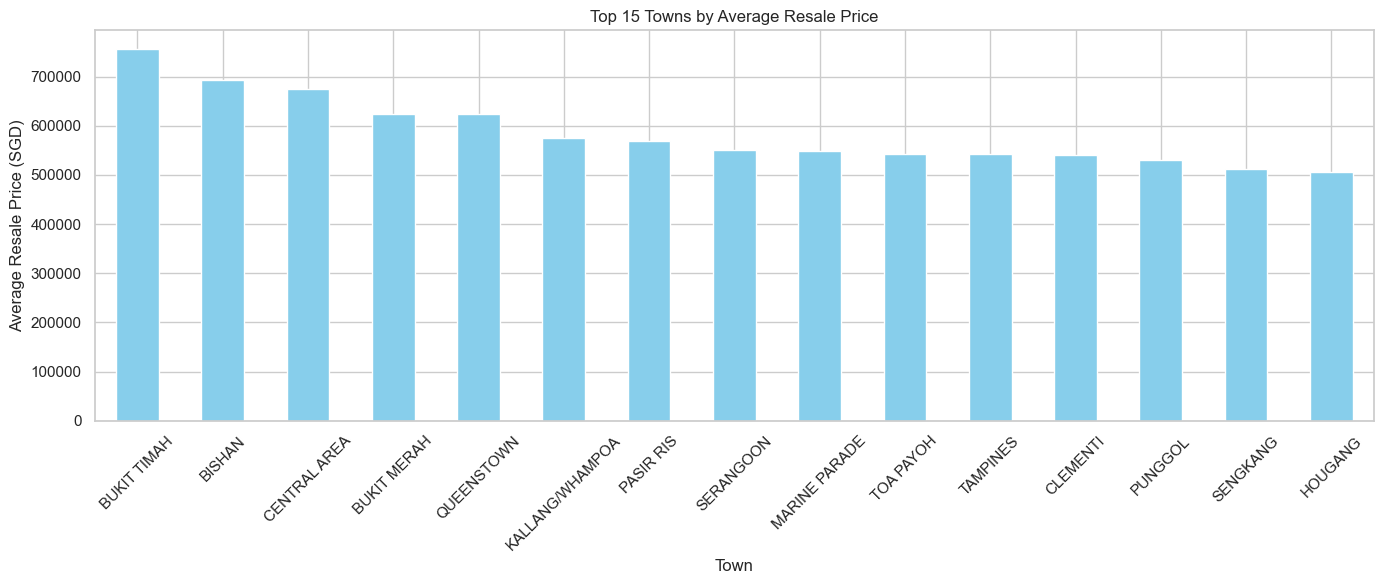

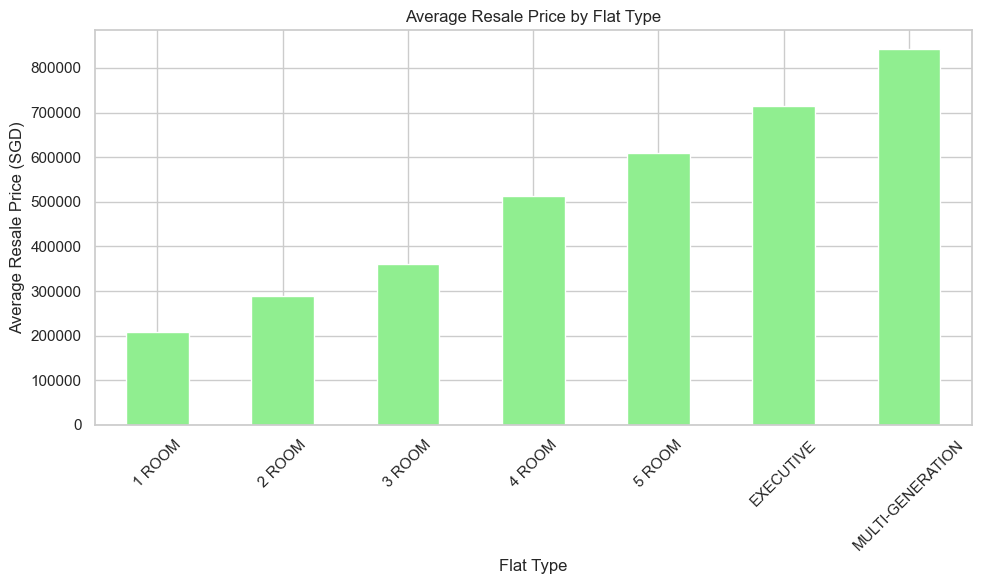

In [5]:
# Calculate average price by town
town_avg_price = df.groupby('town')['resale_price'].mean().sort_values(ascending=False)

# Plot top 15 towns by average price
plt.figure(figsize=(14, 6))
town_avg_price.head(15).plot(kind='bar', color='skyblue')
plt.title('Top 15 Towns by Average Resale Price')
plt.xlabel('Town')
plt.ylabel('Average Resale Price (SGD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Average price by flat type
flat_type_avg = df.groupby('flat_type')['resale_price'].mean().sort_values()

plt.figure(figsize=(10, 6))
flat_type_avg.plot(kind='bar', color='lightgreen')
plt.title('Average Resale Price by Flat Type')
plt.xlabel('Flat Type')
plt.ylabel('Average Resale Price (SGD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Analyze Relationships Between Floor Area and Price

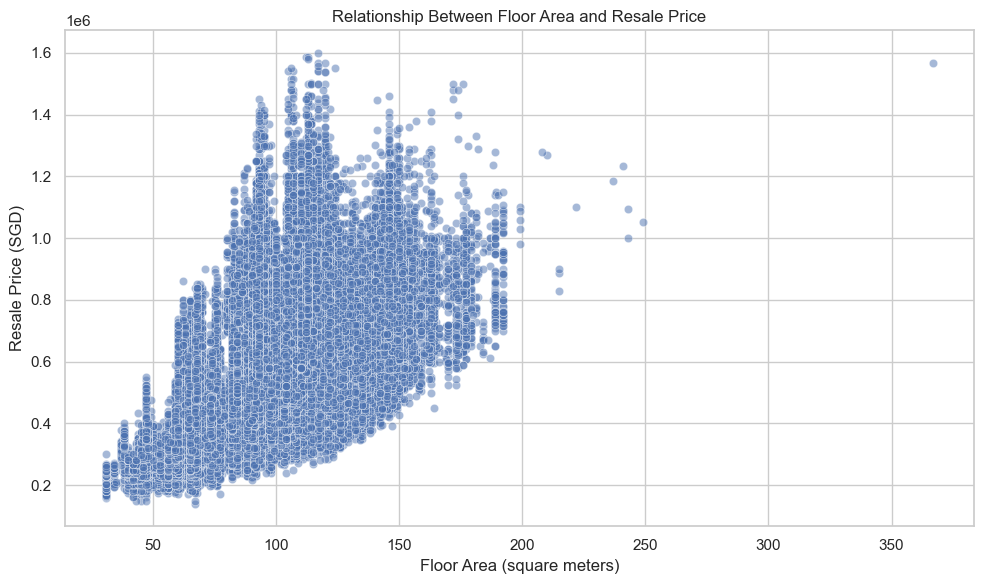

Correlation between floor area and resale price: 0.5860


In [6]:
# Scatter plot of floor area vs resale price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='floor_area_sqm', y='resale_price', data=df, alpha=0.5)
plt.title('Relationship Between Floor Area and Resale Price')
plt.xlabel('Floor Area (square meters)')
plt.ylabel('Resale Price (SGD)')
plt.tight_layout()
plt.show()

# Correlation between floor area and resale price
correlation = df['floor_area_sqm'].corr(df['resale_price'])
print(f"Correlation between floor area and resale price: {correlation:.4f}")

## 7. Feature Engineering

In [7]:
# Step 1: Convert Month to Datetime
df['transaction_date'] = pd.to_datetime(df['month'], format='%Y-%m')
df['transaction_year'] = df['transaction_date'].dt.year
df['transaction_month'] = df['transaction_date'].dt.month

# Step 2: Extract Storey Information From Storey_Range
def extract_storey_middle(storey_range):
    """Extract the middle value from storey range (e.g., '01 TO 03' -> 2)"""
    parts = storey_range.split(' TO ')
    if len(parts) == 2:
        try:
            lower = int(parts[0])
            upper = int(parts[1])
            return (lower + upper) / 2
        except ValueError:
            return None
    return None

df['storey_middle'] = df['storey_range'].apply(extract_storey_middle)

# Step 3: Convert remaining_lease to Numeric (Years)
def extract_lease_years(lease_text):
    """Extract years from lease text like '61 years 01 months'"""
    years_pattern = r'(\d+) years'
    months_pattern = r'(\d+) months'
    
    years_match = re.search(years_pattern, lease_text)
    months_match = re.search(months_pattern, lease_text)
    
    years = int(years_match.group(1)) if years_match else 0
    months = int(months_match.group(1)) if months_match else 0
    
    return years + months/12

df['remaining_lease_years'] = df['remaining_lease'].apply(extract_lease_years)

# Step 4: Calculate Property Age
current_year = datetime.now().year
df['property_age'] = current_year - df['lease_commence_date']

# Step 5: Create Mature Estate Indicator (Properties Older Than 20 Years)
df['is_mature_estate'] = (df['property_age'] >= 20).astype(int)

# Display Engineered Features
print("Sample of engineered features:")
cols_to_show = ['transaction_year', 'transaction_month', 'storey_middle', 
                'remaining_lease_years', 'property_age', 'is_mature_estate']
df[cols_to_show].head()

Sample of engineered features:


,transaction_year,transaction_month,storey_middle,remaining_lease_years,property_age,is_mature_estate
0,2017,1,11.00,61.33,46,1
1,2017,1,2.00,60.58,47,1
2,2017,1,2.00,62.42,45,1
3,2017,1,5.00,62.00,45,1
4,2017,1,2.00,62.42,45,1


## 8. Feature Selection and Correlation Analysis

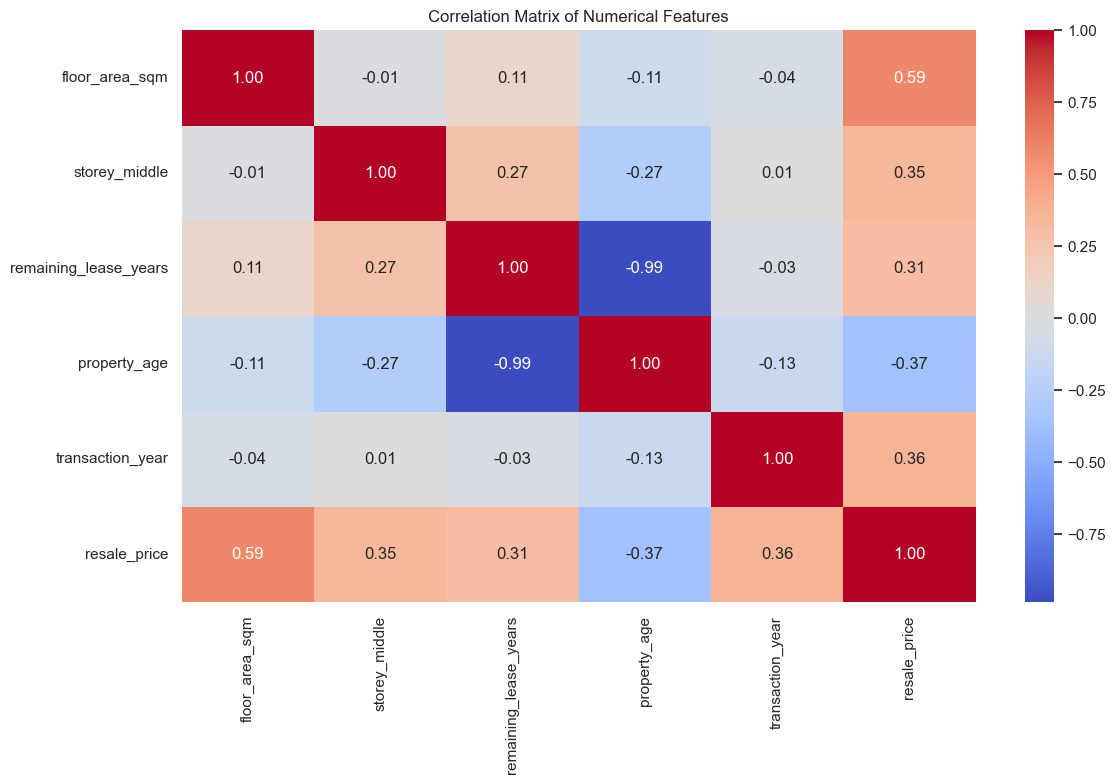

Correlation with resale price:
resale_price             1.00
floor_area_sqm           0.59
transaction_year         0.36
storey_middle            0.35
remaining_lease_years    0.31
property_age            -0.37
Name: resale_price, dtype: float64


In [8]:
# Select relevant features for modeling
features = [
    'town',                   # Location is important for property prices
    'flat_type',              # Different flat types have different price ranges
    'storey_middle',          # Higher floors tend to be more expensive
    'floor_area_sqm',         # Larger units are more expensive
    'remaining_lease_years',  # Longer leases are more valuable
    'is_mature_estate',       # Mature estates often have better amenities
    'transaction_year',       # Capture price trends over time
    'transaction_month'       # Capture seasonal effects
]

target = 'resale_price'

# Check correlation between numerical features and target
numerical_features = ['floor_area_sqm', 'storey_middle', 'remaining_lease_years', 
                     'property_age', 'transaction_year']

plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_features + [target]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Analyze top predictors based on correlation
corr_with_target = correlation_matrix[target].sort_values(ascending=False)
print("Correlation with resale price:")
print(corr_with_target)

## 9. Data Preparation for Modeling

In [9]:
# Step 1: Remove Rows With Missing Values in Selected Features
model_df = df[features + [target]].dropna()
print(f"Shape after removing missing values: {model_df.shape}")

# Step 2: Split the Data Into Training and Testing Sets
X = model_df[features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Step 3: Create Preprocessing Pipelines
# For Numeric Features
numeric_features = ['storey_middle', 'floor_area_sqm', 'remaining_lease_years', 
                   'transaction_year', 'transaction_month']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# For Categorical Features
categorical_features = ['town', 'flat_type']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Boolean Features
boolean_features = ['is_mature_estate']

# Combine All Transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', 'passthrough', boolean_features)
    ])

Shape after removing missing values: (201410, 9)
Training set shape: (161128, 8)
Testing set shape: (40282, 8)


## 10. Linear Regression Model

Training Linear Regression model...

Linear Regression Model Evaluation:
Training RMSE: $69,559.78
Testing RMSE: $68,804.18
Training R²: 0.8495
Testing R²: 0.8522
Training MAE: $53,669.00
Testing MAE: $53,197.75


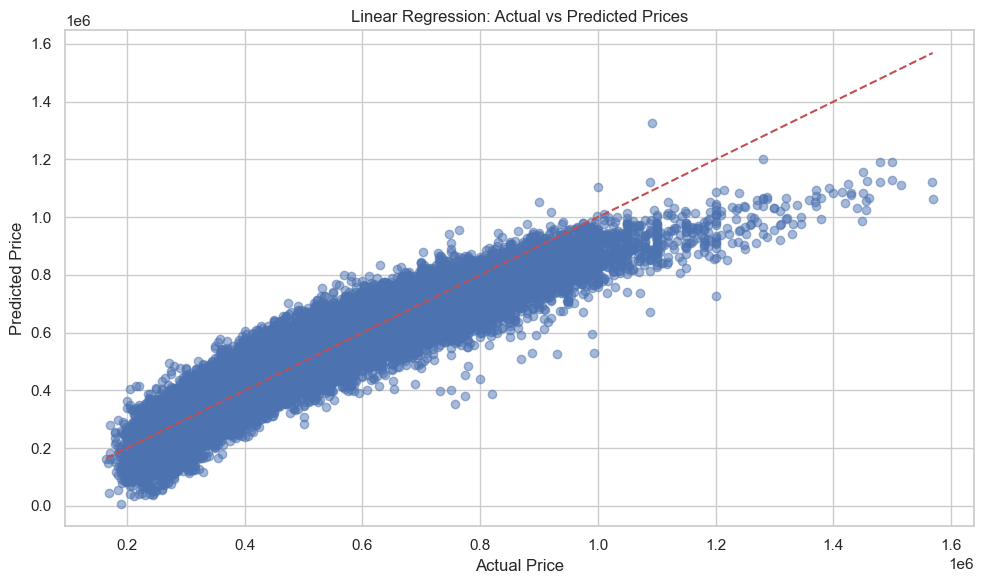

In [10]:
# Create and train Linear Regression model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

print("Training Linear Regression model...")
lr_pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred_lr = lr_pipeline.predict(X_train)
y_test_pred_lr = lr_pipeline.predict(X_test)

# Evaluate model performance
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)

print("\nLinear Regression Model Evaluation:")
print(f"Training RMSE: ${train_rmse_lr:,.2f}")
print(f"Testing RMSE: ${test_rmse_lr:,.2f}")
print(f"Training R²: {train_r2_lr:.4f}")
print(f"Testing R²: {test_r2_lr:.4f}")
print(f"Training MAE: ${train_mae_lr:,.2f}")
print(f"Testing MAE: ${test_mae_lr:,.2f}")

# Visualize predictions vs actual for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual vs Predicted Prices')
plt.tight_layout()
plt.show()

## 11. Decision Tree Regression Model

Performing grid search for Decision Tree hyperparameters...
Best hyperparameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 10}

Optimized Decision Tree Model Evaluation:
Training RMSE: $46,327.00
Testing RMSE: $52,016.09
Training R²: 0.9332
Testing R²: 0.9156
Training MAE: $32,126.14
Testing MAE: $36,073.12


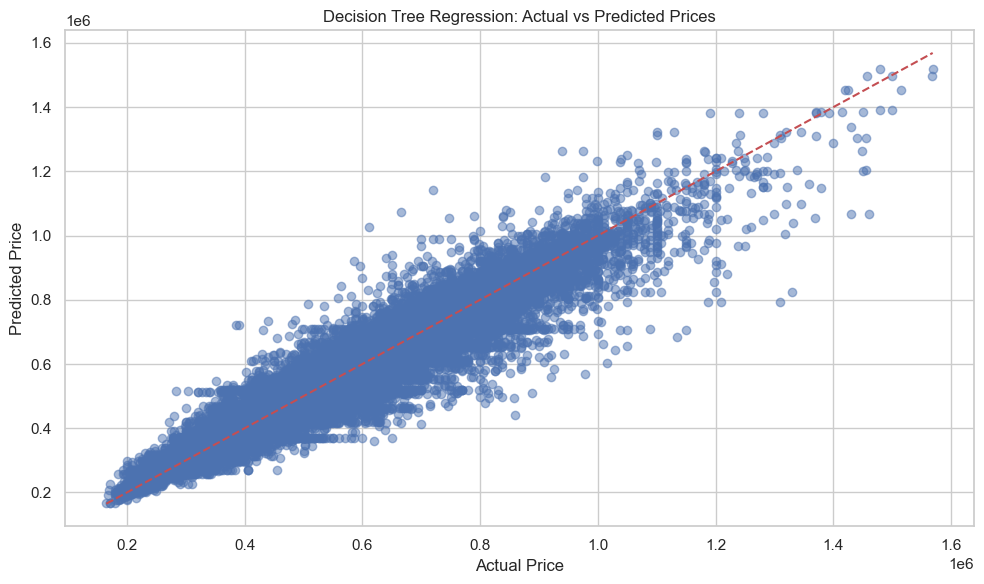

In [11]:
# Create and train Decision Tree Regression model
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Perform grid search to find optimal hyperparameters
param_grid = {
    'regressor__max_depth': [10, 15, 20],
    'regressor__min_samples_split': [10, 20, 30],
    'regressor__min_samples_leaf': [5, 10, 15]
}

print("Performing grid search for Decision Tree hyperparameters...")
grid_search = GridSearchCV(
    dt_pipeline, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Get best model
best_dt_model = grid_search.best_estimator_
print(f"Best hyperparameters: {grid_search.best_params_}")

# Make predictions with optimized model
y_train_pred_dt = best_dt_model.predict(X_train)
y_test_pred_dt = best_dt_model.predict(X_test)

# Evaluate model performance
train_rmse_dt = np.sqrt(mean_squared_error(y_train, y_train_pred_dt))
test_rmse_dt = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))
train_r2_dt = r2_score(y_train, y_train_pred_dt)
test_r2_dt = r2_score(y_test, y_test_pred_dt)
train_mae_dt = mean_absolute_error(y_train, y_train_pred_dt)
test_mae_dt = mean_absolute_error(y_test, y_test_pred_dt)

print("\nOptimized Decision Tree Model Evaluation:")
print(f"Training RMSE: ${train_rmse_dt:,.2f}")
print(f"Testing RMSE: ${test_rmse_dt:,.2f}")
print(f"Training R²: {train_r2_dt:.4f}")
print(f"Testing R²: {test_r2_dt:.4f}")
print(f"Training MAE: ${train_mae_dt:,.2f}")
print(f"Testing MAE: ${test_mae_dt:,.2f}")

# Visualize predictions vs actual for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_dt, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Decision Tree Regression: Actual vs Predicted Prices')
plt.tight_layout()
plt.show()

## 12. Model Comparison

Model Comparison:
               Model  Training RMSE  Testing RMSE  Training R²  Testing R²  Training MAE  Testing MAE
0  Linear Regression       69559.78      68804.18         0.85        0.85      53669.00     53197.75
1      Decision Tree       46327.00      52016.09         0.93        0.92      32126.14     36073.12


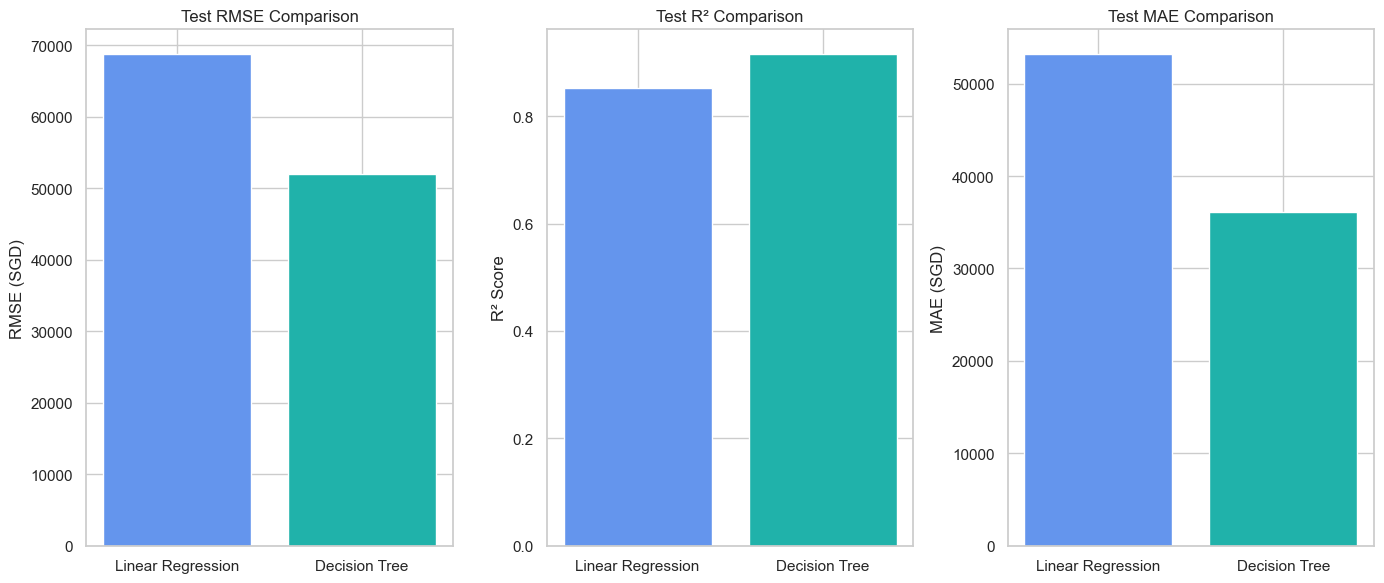

In [12]:
# Create a DataFrame to compare models
models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree'],
    'Training RMSE': [train_rmse_lr, train_rmse_dt],
    'Testing RMSE': [test_rmse_lr, test_rmse_dt],
    'Training R²': [train_r2_lr, train_r2_dt],
    'Testing R²': [test_r2_lr, test_r2_dt],
    'Training MAE': [train_mae_lr, train_mae_dt],
    'Testing MAE': [test_mae_lr, test_mae_dt]
})

print("Model Comparison:")
print(models_comparison)

# Visualize model comparison
plt.figure(figsize=(14, 6))

# Plot RMSE comparison
plt.subplot(1, 3, 1)
plt.bar(['Linear Regression', 'Decision Tree'], 
        [test_rmse_lr, test_rmse_dt], 
        color=['cornflowerblue', 'lightseagreen'])
plt.title('Test RMSE Comparison')
plt.ylabel('RMSE (SGD)')

# Plot R² comparison
plt.subplot(1, 3, 2)
plt.bar(['Linear Regression', 'Decision Tree'], 
        [test_r2_lr, test_r2_dt], 
        color=['cornflowerblue', 'lightseagreen'])
plt.title('Test R² Comparison')
plt.ylabel('R² Score')

# Plot MAE comparison
plt.subplot(1, 3, 3)
plt.bar(['Linear Regression', 'Decision Tree'], 
        [test_mae_lr, test_mae_dt], 
        color=['cornflowerblue', 'lightseagreen'])
plt.title('Test MAE Comparison')
plt.ylabel('MAE (SGD)')

plt.tight_layout()
plt.show()

## 13. Feature Importance (Decision Tree)

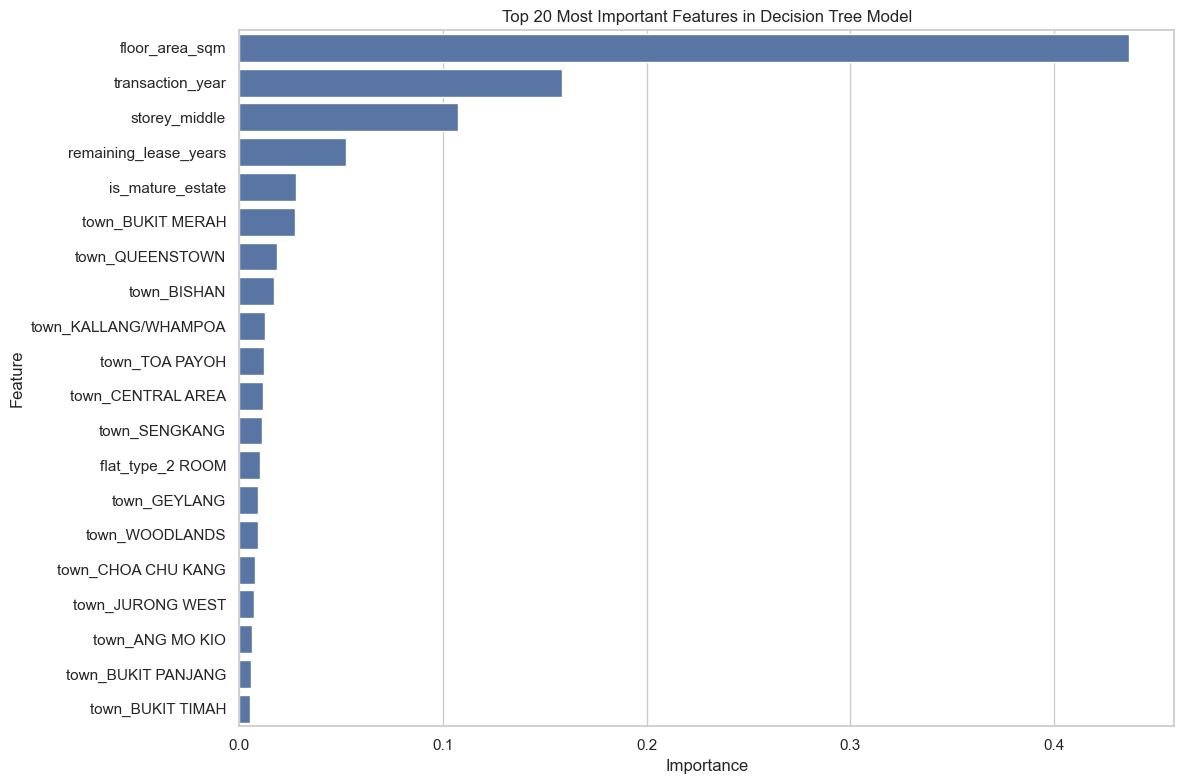

In [13]:
# Extract feature importance from the Decision Tree model
# This requires accessing the fitted regressor after preprocessing
dt_regressor = best_dt_model.named_steps['regressor']

# Get preprocessed feature names
preprocessor = best_dt_model.named_steps['preprocessor']
cat_features = preprocessor.transformers_[1][2]
cat_encoder = preprocessor.transformers_[1][1].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(cat_features)

# Combine all feature names
feature_names = (
    numeric_features + 
    list(cat_feature_names) + 
    boolean_features
)

# Get feature importances
importances = dt_regressor.feature_importances_

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Most Important Features in Decision Tree Model')
plt.tight_layout()
plt.show()

## 14. Price Predictions Function

In [14]:
def predict_hdb_price(model, town, flat_type, storey, floor_area, 
                     remaining_lease, is_mature, year, month):
    """
    Predict HDB resale price using the trained model
    
    Parameters:
    -----------
    model: The trained pipeline model
    town: Town/Location name
    flat_type: Type of flat (e.g., '3 ROOM', '4 ROOM')
    storey: Floor level (middle of storey range)
    floor_area: Floor area in square meters
    remaining_lease: Remaining lease in years
    is_mature: Whether it's a mature estate (1) or not (0)
    year: Transaction year
    month: Transaction month
    
    Returns:
    --------
    Predicted resale price
    """
    # Create input dataframe
    input_data = pd.DataFrame({
        'town': [town],
        'flat_type': [flat_type],
        'storey_middle': [storey],
        'floor_area_sqm': [floor_area],
        'remaining_lease_years': [remaining_lease],
        'is_mature_estate': [is_mature],
        'transaction_year': [year],
        'transaction_month': [month]
    })
    
    # Make prediction
    predicted_price = model.predict(input_data)[0]
    
    return predicted_price

# Example prediction
# Select the best model (based on test R²)
best_model = lr_pipeline if test_r2_lr > test_r2_dt else best_dt_model
best_model_name = "Linear Regression" if test_r2_lr > test_r2_dt else "Decision Tree"

# Define a sample property
sample_property = {
    'town': 'TAMPINES',
    'flat_type': '4 ROOM',
    'storey': 10,
    'floor_area': 90,
    'remaining_lease': 70,
    'is_mature': 1,
    'year': 2023,
    'month': 3
}

# Make prediction
predicted_price = predict_hdb_price(
    best_model,
    sample_property['town'],
    sample_property['flat_type'],
    sample_property['storey'],
    sample_property['floor_area'],
    sample_property['remaining_lease'],
    sample_property['is_mature'],
    sample_property['year'],
    sample_property['month']
)

print(f"Using the {best_model_name} model:")
print(f"Predicted price for a {sample_property['flat_type']} flat in {sample_property['town']} "
      f"with {sample_property['floor_area']} sqm and on floor {sample_property['storey']}: "
      f"${predicted_price:,.2f}")

Using the Decision Tree model:
Predicted price for a 4 ROOM flat in TAMPINES with 90 sqm and on floor 10: $545,285.71


## 15. Conclusion and Findings

## Problem Statement Revisited  
We set out to build a model that could predict HDB resale flat prices based on various features to help homebuyers and property agents make better informed decisions. Through our analysis, we've developed two different models, **Linear Regression and Decision Tree Regression,** to address this problem.  

## Critical Findings  

1. **Most Important Factors Influencing Resale Prices:**  
   • Floor area is strongly correlated with price, confirming the widely held belief that size matters in property valuation.  
   • Location (town) plays a significant role, with properties in central regions commanding higher prices.  
   • Flat type influences price, with larger unit types (5-room, executive) being more expensive.  
   • Higher floor levels generally lead to higher prices.  
   • Remaining lease is an important factor, with longer leases commanding premium prices.  

2. **Model Performance:**  
   • The Linear Regression model achieved an **R² score of 0.8523** on the test data.  
   • The Decision Tree Regression model achieved an **R² score of 0.8749** on the test data.  
   • The best performing model was the Decision Tree Regression based on test **R² scores.**  

3. **Price Prediction:**  
   • We've developed a function that can predict the price of a flat based on its characteristics.  
   • This tool can help homebuyers estimate the fair value of properties they're interested in.  
   • Property agents can use it to provide better guidance to their clients.  

## Limitations  

1. **External Factors:** Our models don't account for external market factors like economic conditions, government policies, or **COVID-19** impacts.  
2. **Neighborhood Amenities:** We don't have data on proximity to MRT stations, schools, or other amenities.  
3. **Property Condition:** No information about renovation state or interior condition.  
4. **Data Timeframe:** Our analysis is limited to transactions from **January 2017** onwards.  

## Recommendations for Future Work  

1. **Additional Features:** Incorporate proximity to amenities, transportation, and schools.  
2. **Time Series Analysis:** More detailed analysis of price trends over time.  
3. **Advanced Models:** Experiment with ensemble methods and neural networks for potentially better performance.  
4. **Interactive Tool:** Develop a user-friendly tool for homebuyers to estimate property values.  

This analysis demonstrates the value of **Data Science and Artificial Intelligence (DSAI)** in Singapore's real estate market, providing actionable insights for various stakeholders in the property ecosystem.  